In [182]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pickle
import nmslib
import collections
import numpy as np
import pandas as pd
import scipy.sparse as ss
import matplotlib.pyplot as plt
import matplotlib
from typing import List
from sklearn.feature_extraction.text import TfidfTransformer
from lib.sparse_tools import dense_sparse_dot, dense_sparse_add, sparse_sparse_dot
from lib.argmax_tools import BruteforceArgmax, ANNArgmax
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import linear_kernel
from sklearn.utils.extmath import safe_sparse_dot
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
matplotlib.rcParams.update({'font.size': 12})

Our datasets:

In [184]:
datasets_names = ("LSHTC1", "DMOZ", "WIKI_Small", "WIKI_50K", "WIKI_100K")
dataset_dir = "../data"
out_dir = "../data/parsed"

In [185]:
%%time

# Read the dataset.

# dataset_name = "WIKI_Small"
# dataset_name = "DMOZ"
dataset_name = "LSHTC1"
# dataset_name = "20newsgroups"

with open(os.path.join(out_dir, "%s_train.dump" % dataset_name), "rb") as fin:
    X_train = pickle.load(fin)
with open(os.path.join(out_dir, "%s_train_out.dump" % dataset_name), "rb") as fin:
    y_train = pickle.load(fin)
with open(os.path.join(out_dir, "%s_heldout.dump" % dataset_name), "rb") as fin:
    X_heldout = pickle.load(fin)
with open(os.path.join(out_dir, "%s_heldout_out.dump" % dataset_name), "rb") as fin:
    y_heldout = pickle.load(fin)
with open(os.path.join(out_dir, "%s_test.dump" % dataset_name), "rb") as fin:
    X_test = pickle.load(fin)
with open(os.path.join(out_dir, "%s_test_out.dump" % dataset_name), "rb") as fin:
    y_test = pickle.load(fin)

n_classes = 0
for dataset_part in ("train", "heldout", "test"):
    with open(os.path.join(out_dir, "%s_%s_out.dump" % (dataset_name, dataset_part)), "rb") as fin:
        labels = pickle.load(fin)
        n_classes = max(n_classes, max(labels) + 1)

CPU times: user 108 ms, sys: 373 ms, total: 481 ms
Wall time: 817 ms


In [186]:
classes_objects = collections.defaultdict(list)
classes_cnt = [0] * n_classes
for i, y in enumerate(y_train):
    classes_objects[y].append(i)
    classes_cnt[y] += 1
classes_cnt = np.array(classes_cnt)

---

In [26]:
a = ss.random(1000, 10000).tocsr()
bT = ss.random(2000, 10000).T
bTR = ss.random(2000, 10000).T.tocsr()
bTC = ss.random(2000, 10000).T.tocsc()

In [27]:
%timeit a.dot(bT)

34.4 ms ± 658 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit a.dot(bTR)

27.6 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit a.dot(bTC)

29.7 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Average IoU of classes (as bag-of-words of their documents):

In [105]:
classes_tokens = collections.defaultdict(set)

In [106]:
%%time

for a, b, y in tqdm(zip(X_train.indptr, X_train.indptr[1:], y_train)):
    classes_tokens[y] |= set(X_train.indices[a:b])

126871it [00:05, 25231.02it/s]

CPU times: user 4.49 s, sys: 453 ms, total: 4.94 s
Wall time: 5.03 s


In [ ]:
%%time

avg_iou_num = 0
avg_iou_den = 0

for y1, c1 in tqdm(classes_tokens.items()):
    for y2, c2 in classes_tokens.items():
        u = len(c1 | c2)
        if u > 0:
            iou = len(c1 & c2) / u
            avg_iou_num += iou
            avg_iou_den += 1

In [152]:
avg_iou_num/avg_iou_den

0.11863847316584965

---

Iris datasets:

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [ ]:
iris_data = load_iris()
X, y = iris_data["data"], iris_data["target"]

In [ ]:
X = np.hstack([X, np.ones(X.shape[0]).reshape(-1, 1)])
X = ss.csr_matrix(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

---

In [187]:
%%time

# X_train, X_test = normalize(X_train, norm="l1"), normalize(X_test, norm="l1")

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


In [188]:
%%time

X_train = ss.hstack([X_train, np.ones(X_train.shape[0]).reshape(-1, 1)])
X_heldout = ss.hstack([X_heldout, np.ones(X_heldout.shape[0]).reshape(-1, 1)])
X_test = ss.hstack([X_test, np.ones(X_test.shape[0]).reshape(-1, 1)])
X_train, X_heldout, X_test = ss.csr_matrix(X_train), ss.csr_matrix(X_heldout), ss.csr_matrix(X_test)

CPU times: user 997 ms, sys: 1.07 s, total: 2.07 s
Wall time: 3.75 s


---

### M-SVM from liblinear

In [156]:
import liblinear

In [44]:
%time m = liblinear.train(y_train[:1000], X_train[:1000], "-s 4")

CPU times: user 1min 22s, sys: 4.15 s, total: 1min 27s
Wall time: 1min 33s


In [53]:
%time liblinear.save_model("msvm.mdl", m)

CPU times: user 55.8 s, sys: 2.5 s, total: 58.3 s
Wall time: 1min


In [248]:
X_train.shape[0] * 5

65960

---

In [14]:
np.random.seed(0)
index_ids = np.random.randint(X_train.shape[0], size=2000)
query_ids = np.random.randint(len(index_ids), size=100)

In [15]:
%%time

data = X_train[index_ids] #.toarray()
query = data[query_ids]

CPU times: user 8.32 ms, sys: 4.13 ms, total: 12.4 ms
Wall time: 11.2 ms


### nmslib for ANN

In [12]:
import nmslib

In [15]:
%%time

index = nmslib.init(method="sw-graph", space="cosinesimil_sparse",
                    data_type=nmslib.DataType.SPARSE_VECTOR)
#index.addDataPointBatch(ss.csr_matrix((100, 1000), dtype=np.float32), range(100))
#index.createIndex({'indexThreadQty': 4}, print_progress=False)
index.createIndex({'indexThreadQty': 4})

CPU times: user 236 µs, sys: 1.58 ms, total: 1.81 ms
Wall time: 1.79 ms


In [102]:
%%time

start_id = len(index)
index.addDataPointBatch(data, range(start_id, start_id + data.shape[0]))
index.createIndex({'indexThreadQty': 4}, print_progress=False)

CPU times: user 910 ms, sys: 6.66 ms, total: 917 ms
Wall time: 279 ms


In [103]:
%time index.saveIndex("index.dump")

CPU times: user 14.9 ms, sys: 13.2 ms, total: 28.1 ms
Wall time: 30.1 ms


In [36]:
%timeit nbrs = index.knnQueryBatch(query, k=1, num_threads=4)

16.6 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%time nbrs = index.knnQueryBatch(data, k=1, num_threads=4)

CPU times: user 4.17 s, sys: 13.5 ms, total: 4.18 s
Wall time: 1.19 s


In [18]:
%time nbrs = index.knnQueryBatch(X_train[228:328], k=1, num_threads=4)

CPU times: user 38.2 ms, sys: 1.56 ms, total: 39.8 ms
Wall time: 13.5 ms


In [43]:
sum([x[0][0] == y for x, y in zip(nbrs, index_ids)]) / 100

18.82

In [44]:
sum([x[0][0] == y for x, y in zip(nbrs, index_ids)]) / 2000

0.941

---

### PySparNN for ANN

In [47]:
import pysparnn.cluster_index as ci

In [48]:
%%time

# build the search index!
data_to_return = list(range(X_train.shape[0]))
cp = ci.MultiClusterIndex(X_train, data_to_return, num_indexes=1)

CPU times: user 3min 22s, sys: 3.77 s, total: 3min 25s
Wall time: 3min 31s


In [51]:
%timeit nbrs = cp.search(data, k=1, return_distance=False)

4.19 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
sum([x[0] == y for x, y in zip(nbrs, index_ids)]) / 2000

0.981

---

In [5]:
"""
Vector in a form: a * v
"""
class WeightVector:
    # TODO: add squared norm

    def __init__(self, dimension):
        self.d = dimension
        self.a = 1.0
        self.v = np.zeros(self.d, dtype=np.float64)

    def sparse_dot(self, u: ss.csr_matrix):
        return dense_sparse_dot(self.v, u) * self.a

    def sparse_add(self, u: ss.csr_matrix, s: float):
        dense_sparse_add(self.v, u * (s / self.a), inplace=True)
    
    def add(self, other, s: float):
        self.v *= self.a
        self.v += other.v * other.a * s
        self.a = 1.0

    def scale(self, s: float):
        if abs(s) < 1e-9:
            self.__init__(self.d)
        else:
            self.a *= s
    
    def get_snorm(self):
        return (self.a ** 2) * np.dot(self.v, self.v)

In [10]:
"""
Matrix in a form: a * [v_i], i=1...n
"""


class WeightMatrix:
    def __init__(self, dim):
        self.dim = n, d = dim
        self.a = 1.0
        self.snorm = 0.
        self.m = [ss.csr_matrix((1, d), dtype=np.float32) for _ in range(n)]

    def sparse_dot(self, ix: int, v: ss.csr_matrix):
        return sparse_sparse_dot(self.m[ix], v) * self.a

    def sparse_add(self, ix: int, v: ss.csr_matrix, s: float):
        old_ix_norm = np.dot(self.m[ix].data, self.m[ix].data)
        self.m[ix] += v * (s / self.a)
        new_ix_norm = np.dot(self.m[ix].data, self.m[ix].data)
        self.snorm += (new_ix_norm - old_ix_norm) * (self.a * self.a)
        return self.m[ix] * self.a

    def scale(self, s: float):
        if abs(s) < 1e-32:
            self.__init__(self.dim)
        else:
            self.a *= s
            self.snorm *= (s*s)

In [7]:
def stochastic_pegasos(X: np.array, y: np.array, pos_class: int, random_seed=None) -> List[np.ndarray]:    
    n, d = X.shape

    labels = ((y == pos_class) * 2 - 1)

    # TODO: make parameters
    max_iter = 150000
    num_to_avg = 120000
    lambd = 0.0005
    k = 100

    if random_seed is not None:
        np.random.seed(random_seed)
    random_ids = np.random.choice(n, size=max_iter * k)

    avg_scale = min(max_iter, num_to_avg)
    avg_wv = WeightVector(d)
    wv = WeightVector(d)
    wvs = []

    for i in tqdm(range(max_iter)):
        x_ids = random_ids[i * k : (i + 1) * k]
        eta = 1. / (lambd * (i + 2))
        grad_ixs, grad_weights = [], []
        for j in x_ids:
            x = X.getrow(j)
            pred = wv.sparse_dot(x)
            label = labels[j]
            if label * pred < 1:
                grad_ixs.append(j)
                grad_weights.append(eta * label / k)
        # Scale wv
        wv.scale(1. - eta * lambd)
        # Add sub-gradients
        for grad_ix, grad_w in zip(grad_ixs, grad_weights):
            wv.sparse_add(X.getrow(grad_ix), grad_w)
        # Projection step
        wv.scale(min(1., 1. / np.sqrt(lambd * wv.get_snorm())))
        # Average weights
        if i >= max_iter - num_to_avg:
            avg_wv.add(wv, 1. / avg_scale)
            if (i + 1) % 100 == 0:
                wvs.append(avg_wv.a * avg_wv.v)
        else:
            if (i + 1) % 100 == 0:
                wvs.append(wv.a * wv.v)
    
    return wvs

In [8]:
def multi_pegasos(X: np.array, y: np.array, random_seed=None) -> List[np.ndarray]:    
    n, d = X.shape

    # TODO: make parameters
    max_iter = 150000
    lambd = 0.0005
    k = 100

    W = WeightMatrix((n_classes, d))
    #amax = BruteforceArgmax(W)
    amax = ANNArgmax()

    if random_seed is not None:
        np.random.seed(random_seed)
    random_ids = np.random.choice(n, size=max_iter * k)

    #avg_scale = min(max_iter, num_to_avg)
    #avg_wv = WeightVector(d)

    for i in tqdm(range(max_iter)):
        x_ids = random_ids[i * k : (i + 1) * k]
        xs = X[x_ids]
        eta = 1. / (lambd * (i + 2))
        ys = y[x_ids]
        rs = amax.query(xs)
        grad_ixs, grad_weights = [], []
        for j_, y_, r_, x_  in zip(x_ids, ys, rs, xs):
            loss = max(0, 1 + W.sparse_dot(r_, x_) - W.sparse_dot(y_, x_))
            if loss > 0:
                grad_ixs.append((y_, j_))
                grad_weights.append(+eta / k)
                grad_ixs.append((r_, j_))
                grad_weights.append(-eta / k)
        # Scale weight matrix
        W.scale(1. - eta * lambd)
        # Add sub-gradients and project rows onto a sphere of r=1
        update = {}
        for (class_ix, obj_ix), grad_w in zip(grad_ixs, grad_weights):
            upd = W.sparse_add(class_ix, X.getrow(obj_ix), grad_w)
            # TODO: FASTER, UNNEEDED?
            #upd *= min(1., 1. / np.sqrt(lambd * sparse_sparse_dot(upd, upd)))
            if upd.nnz > 0:
                update[class_ix] = upd
        class_ixs = list(update.keys())
        new_values = ss.vstack(list(update.values()))
        amax.update(class_ixs, new_values)

    return W

In [ ]:
%time wvs = multi_pegasos(X_train, y_train, random_seed=0)

  1%|          | 1467/150000 [11:04<18:41:52,  2.21it/s]

In [124]:
%time wvs = stochastic_pegasos(X_train, y_train, pos_class=pos_class, random_seed=0)

100%|██████████| 150000/150000 [2:49:54<00:00, 14.71it/s]

CPU times: user 20min 55s, sys: 1min 40s, total: 22min 35s
Wall time: 2h 49min 54s


---

**Оценка качества:**

In [126]:
w_pegasos = wvs[-1].reshape(-1, 1)

In [127]:
w_pegasos.T

array([[ 0.02137611, -0.09405117,  0.02113176, ...,  0.        ,
        -0.51107077, -0.51107077]])

In [128]:
%%time

clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train == pos_class)
w_lr = clf.coef_.reshape(-1, 1)

CPU times: user 1min 40s, sys: 2.26 s, total: 1min 42s
Wall time: 1min 43s


In [129]:
y_true = (y_test == pos_class)
y_pred_pegasos = (X_test.dot(w_pegasos) > 0).T[0]
y_pred_lr = (X_test.dot(w_lr) > 0).T[0]

In [130]:
collections.Counter(y_pred_pegasos)

Counter({False: 34301, True: 205})

In [131]:
collections.Counter(y_pred_lr)

Counter({False: 34201, True: 305})

In [132]:
print(classification_report(y_true, y_pred_pegasos))

             precision    recall  f1-score   support

      False       0.99      1.00      1.00     34090
       True       0.71      0.35      0.47       416

avg / total       0.99      0.99      0.99     34506



In [133]:
print(classification_report(y_true, y_pred_lr))

             precision    recall  f1-score   support

      False       0.99      1.00      0.99     34090
       True       0.57      0.42      0.48       416

avg / total       0.99      0.99      0.99     34506



In [134]:
confusion_matrix(y_true, y_pred_pegasos)

array([[34031,    59],
       [  270,   146]])

In [135]:
confusion_matrix(y_true, y_pred_lr)

array([[33959,   131],
       [  242,   174]])

---

In [136]:
%%time

f1s_train = []
f1s_test = []

for w in tqdm(wvs):
    w = w.reshape(-1, 1)
    y_true = (y_train == pos_class)
    y_pred = (X_train.dot(w) > 0).T[0]
    f1s_train.append(f1_score(y_true, y_pred))
    y_true = (y_test == pos_class)
    y_pred = (X_test.dot(w) > 0).T[0]
    f1s_test.append(f1_score(y_true, y_pred))

100%|██████████| 1500/1500 [04:47<00:00,  5.21it/s]


CPU times: user 4min 34s, sys: 11.9 s, total: 4min 46s
Wall time: 4min 47s


In [140]:
y_train[y_train == 11].shape

(4757,)

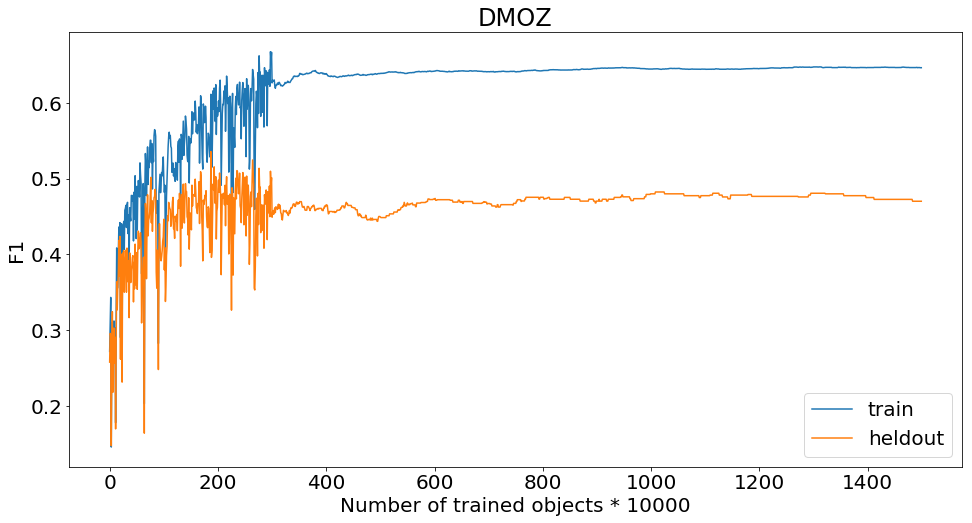

In [137]:
plt.figure(figsize=(16, 8))
plt.plot(range(len(f1s_train)), f1s_train)
plt.plot(range(len(f1s_test)), f1s_test)
plt.title("DMOZ")
plt.ylabel("F1")
plt.xlabel("Number of trained objects * 10000")
plt.legend(["train", "heldout"], loc="lower right")
plt.savefig("DMOZ_binary.eps", bbox_inches="tight")
plt.savefig("DMOZ_binary.png", bbox_inches="tight", dpi=300)

---

In [189]:
%%time

with open("W_%s.dump" % dataset_name, "rb") as fin:
    W = pickle.load(fin)

CPU times: user 452 ms, sys: 850 ms, total: 1.3 s
Wall time: 1.56 s


In [190]:
(W.m[0].data * W.a)

array([-2.33177881e-05,  3.33111259e-06, -3.33111259e-06, ...,
       -3.33111259e-06, -7.52181060e-08, -1.37005409e-05])

In [191]:
W.snorm

0.005079895252857461

In [192]:
sum([np.dot(r.data, r.data) for r in W.m]) * (W.a * W.a)

0.005079895252857481

In [193]:
%time Ws = ss.vstack(W.m)

CPU times: user 180 ms, sys: 35 ms, total: 215 ms
Wall time: 219 ms


In [194]:
collections.Counter(y_train).most_common(20)

[(12, 2863),
 (33, 849),
 (212, 824),
 (0, 755),
 (340, 510),
 (702, 434),
 (3, 432),
 (255, 389),
 (627, 383),
 (196, 370),
 (172, 335),
 (101, 329),
 (699, 328),
 (636, 315),
 (210, 311),
 (240, 286),
 (220, 281),
 (753, 270),
 (1343, 267),
 (149, 265)]

In [195]:
Ws

<12294x409775 sparse matrix of type '<class 'numpy.float64'>'
	with 7769278 stored elements in Compressed Sparse Row format>

---

In [196]:
num_candidates = 1
num_threads = 4

In [197]:
%time

ix_nz = [i for i, v in enumerate(Ws) if v.nnz != 0]
Ws_nz = Ws[ix_nz]
nz_to_z = {k: v for k, v in enumerate(ix_nz)}

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [207]:
%%time

index = nmslib.init(method="hnsw", space="cosinesimil_sparse",
                    data_type=nmslib.DataType.SPARSE_VECTOR)
index.addDataPointBatch(Ws_nz)
index.createIndex({"indexThreadQty": num_threads})

CPU times: user 4min 46s, sys: 537 ms, total: 4min 47s
Wall time: 1min 23s


In [208]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, l.shape[0], n):
        yield l[i:i + n]

In [209]:
chunk_size = 1000

def predict(X):
    y_pred = []
    for x_chunk in tqdm(chunks(X, chunk_size)):
        results = index.knnQueryBatch(x_chunk, k=num_candidates, num_threads=num_threads)
        for x, (nn_ids, _) in zip(x_chunk, results):
            # ix = np.argmax(cosine_similarity(Ws_nz[nn_ids], x).T[0])
            # ix = np.argmax(safe_sparse_dot(Ws_nz[nn_ids], x.T, dense_output=True).T[0])
            ix = 0
            class_id = nz_to_z[nn_ids[ix]]
            y_pred.append(class_id)
    return y_pred

---

#### Train quality:

In [ ]:
%time y_pred_train = predict(X_train)

In [ ]:
%time f1_score(y_train, y_pred_train, average="macro")

In [ ]:
%time f1_score(y_train, y_pred_train, average="micro")

---

#### Test quality:

In [213]:
%time y_pred_test = predict(X_test)

32it [00:18,  1.73it/s]

CPU times: user 59.7 s, sys: 126 ms, total: 59.8 s
Wall time: 18.5 s


In [214]:
%time f1_score(y_test, y_pred_test, average="macro")

CPU times: user 32.6 ms, sys: 1.61 ms, total: 34.2 ms
Wall time: 33.6 ms


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.0646370073303858

In [215]:
%time f1_score(y_test, y_pred_test, average="micro")

CPU times: user 34.7 ms, sys: 1.92 ms, total: 36.6 ms
Wall time: 36.3 ms


0.0754145910839271

---

#### Heldout quality:

In [210]:
%time y_pred_heldout = predict(X_heldout)

5it [00:02,  1.68it/s]

CPU times: user 9.59 s, sys: 27.5 ms, total: 9.62 s
Wall time: 2.99 s


In [211]:
%time f1_score(y_heldout, y_pred_heldout, average="macro")

CPU times: user 7.38 ms, sys: 2.21 ms, total: 9.59 ms
Wall time: 7.74 ms


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.06043837593309581

In [212]:
%time f1_score(y_heldout, y_pred_heldout, average="micro")

CPU times: user 7.3 ms, sys: 980 µs, total: 8.28 ms
Wall time: 7.35 ms


0.0776

---

In [147]:
sum([x.nnz for x in W.m]) / (len(W.m) * W.m[0].shape[1])

0.004194435218481212

---

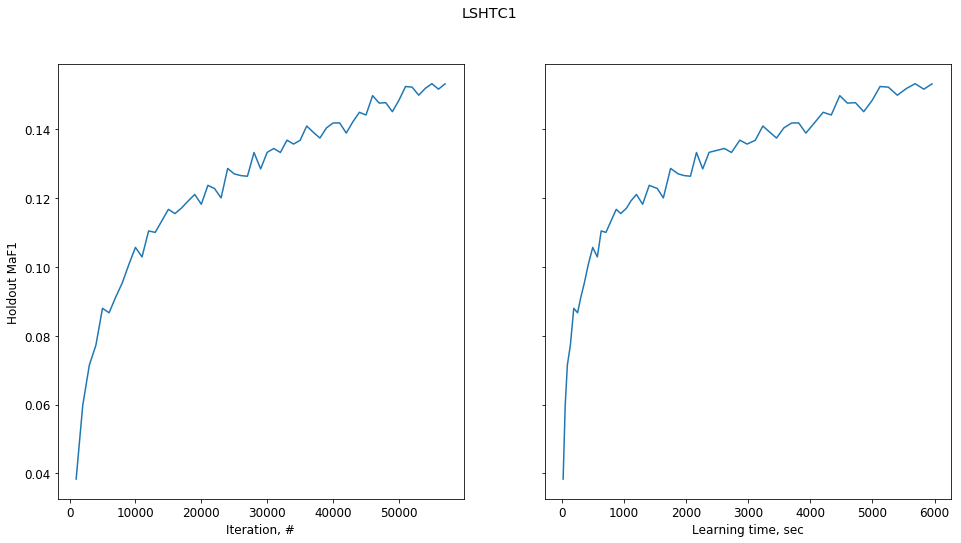

In [229]:
log_dataset_name = "LSHTC1"

log = pd.read_csv("log_%s.txt" % log_dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plt.suptitle(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
axes[0].plot(log["i"], log["maf1"])
axes[1].plot(log["learning_time"], log["maf1"])
plt.savefig("fig_%s.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

---